# **딥러닝에 의한 이진 분류분석 사례**

# 0. 필요한 라이브러리 설치

 분석을 진행하기 전에 필요한 라이브러리를 먼저 설치한다.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. 데이터 준비

드라이브에 저장된 데이터 파일을 사용하기 위해 드라이브를 마운트한다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


해당 데이터 파일을 df라는 객체로 저장하고, 각 열의 이름을 y, x1, x2로 주어 데이터 프레임 형태로 만든다.

In [ ]:
data = '/content/drive/MyDrive/감성공학/result.txt'
df = pd.read_csv(data, sep=',' )
df.columns = ["y", 'x1', 'x2']
df

,y,x1,x2
0,0,380,3.61
1,1,660,3.67
2,1,800,4.00
3,1,640,3.19
4,0,520,2.93
...,...,...,...
395,1,620,4.00
396,1,560,3.04
397,0,460,2.63
398,1,700,3.65


y는 0과 1로 이루어진 피처로 데이터 파악을 위해 value_count()로 value들을 세준다. 1은 287개, 0은 113개로 이루어져 있다.

In [ ]:
df['y'].value_counts()

1    287
0    113
Name: y, dtype: int64

x축을 df의 x1, y축을 df의 x2로 하는 y의 위치를 파악할 수 있는 산포그래프를 그린다. 0은 빨강, 1은 파랑으로 나타내면 0은 주로 왼쪽 아래, 1은 오른쪽 위에 분포한다.

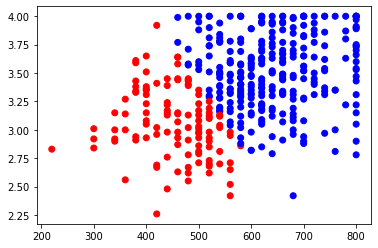

In [ ]:
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue'}
ax.scatter(df['x1'], df['x2'], c=df['y'].map(colors))
plt.show()

데이터 준비 및 탐색이 끝난 후 데이터를 train 데이터셋, validation 데이터셋, test 데이터셋 세가지로 나눈다. 총 400개의 데이터 중 test데이터셋과 validation 데이터셋을 각각 80개로 사용한다. 

In [ ]:
n = 400
ts = 80
vs =80
print(n,ts,vs)

400 80 80


사이킷런의 train_test_split 모듈을 사용하여 데이터를 나눈다. test_size는 테스트 데이터셋의 갯수를 의미하고, random_state는 데이터를 분할할 때 난수를 지정하여 셔플하는 횟수를 의미한다.


train_test_split을 사용하여 위에서 정의한대로 test데이터셋과 validation데이터셋은 각각 80개로 지정하고 random_state는 100회를 지정한다. train데이터셋은 400개 중 160개를 뺀 240개임을 확인한다.

In [ ]:
train_df, test_df = train_test_split(df, test_size=ts,random_state=100)
train_df, val_df = train_test_split(train_df, test_size=vs,random_state=100)
len(train_df)

240

train데이터셋의 y열을 히스토그램으로 확인한 결과 0은 약 70개, 1은 약 170개인 것을 확인할 수 있다.

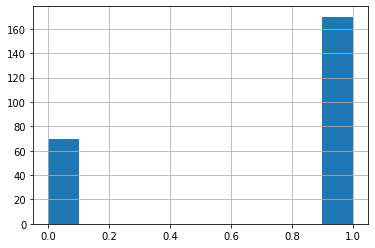

In [ ]:
train_df['y'].hist()

# 2. 모델링

pop함수는 특정 레이블을 뽑아낼 때 유용한 함수로 train_df(훈련용 데이터셋)에서 y를 뽑아내 y_train으로 두고 나머지는 x_train으로 둔다. test_df(테스트용 데이터셋)과 val_df(검증용 데이터셋) 역시 같은 방법으로 y를 뽑아낸다.

In [ ]:
y_train = train_df.pop('y')
x_train = train_df
y_test = test_df.pop('y')
x_test = test_df
y_val = val_df.pop('y')
x_val = val_df

pop함수를 사용한 후 만들어진 x_train을 확인하면 train_df에서 y가 빠진 모습인 것을 확인할 수 있다.

In [ ]:
x_train

,x1,x2
6,560,2.98
251,620,3.21
45,460,3.45
254,740,3.52
182,700,4.00
...,...,...
65,600,3.59
132,580,3.40
321,460,3.58
336,520,3.15


np.array 함수를 사용하여 train_df을 배열로 만들고, shape 함수로 배열의 형태를 확인한다. 

In [ ]:
train_features = np.array(train_df)
print(np.shape(train_features))

(240, 2)


본격적인 모델링 과정으로 케라스 sequential 모델을 만들어준다. 코드 설명에 앞서 설명을 하자면 순차적 모델은 순차적으로 레이어를 더하는 모델이다. 각 레이어는 add()로 사용할 수 있는데 출력 뉴런의 수를 설정해주고 활성화 함수도 설정할 수 있다. 활성화 함수에는 sigmoid, tanh, relu 등이 있는데 여기서는 sigmoid와 relu만 설명하고 넘어가겠다.
sigmoid 함수는 결과를 0과 1 사이로 만들어주기 때문에 이진 분류 문제에서 주로 쓰이고 relu함수는 학습이 빠르게 잘 되어서 잘 쓰이는 함수다.

첫번째 레이어의 출력 뉴런은 16, 활성화 함수는 relu로 설정하고 첫 번째 레이어에는 input_shape로 입력값의 형태를 정한다. 두번째 레이어 또한 출력 뉴런 갯수 16개, 활성화 함수 relu로 설정한다. 다음은 과적합을 줄일 수 있는 dropout을 설정할 수 있다. 그 다음 레이어는 출력 뉴런수 1, 활성화함수 sigmoid로 설정한다. 

모델 구성을 마친 후 훈련을 시켜준다. optimizer, loss, metrics를 지정해줄 수 있는데 optimizer(최적화함수)은 손실함수의 결과값을 최소화하는 모델의 가중치를 찾는다. 최적화 함수 중 adm은 최적화함수 momentum과 RMSProp를 병합한 것으로 가장 많이 쓰이는 것이다. 다음 loss(손실함수)는 모델이 훈련 중에 최소화하려는 양을 계산하는 것이다. binary_crossentropy는 이진분류 문제, 즉 0과 1의 값을 가질 때 사용한다. metrics는 측정항목으로 정확도를 사용한다.



In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(16, activation='relu', 
                             input_shape=(train_features.shape[-1],)))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dropout(0.5))  
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

구현한 모델을 요약한 결과다.

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 16)                48        
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


순차 모델을 시각화하면 다음과 같다. 

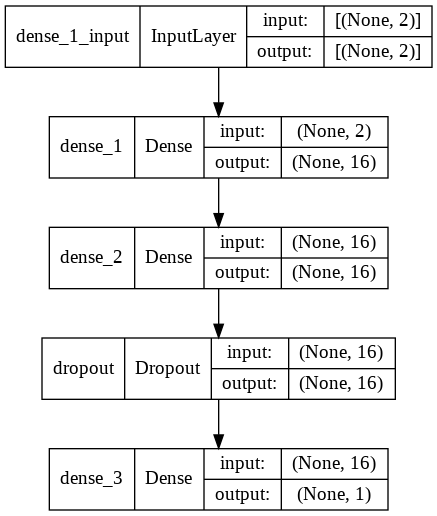

In [ ]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes = True)

# 3. Training

케라스 콜백함수는 모델을 일정 간격으로 저장하여 나중에 저장된 상태에서 훈련을 계속 할 수 있도록 한다. 

모델의 파일명은 'model.hdf5'로 한다. monitor인자는 모델을 저장할 때 기준이 되는 값으로 validation 데이터셋의 정확도가 가장 높을 때 저장된다. 다음 verbose인자가 1일 때는 모델이 저장될 때 안내문이 화면에 표시된다. 그리고, save_best_only를 True로 설정하여 monitor값이 가장 좋을 때 저장되도록 한다. mode인자는 정확도가 클수록 좋으므로 max로 설정해준다. 다음 save_freq 인자는 epoch으로 설정하여 매 에폭마다 모델이 저장되도록 한다. 마지막 save_weights_only는 모델의 weights만 저장되도록 True로 설정한다.

In [ ]:
save_weights = tf.keras.callbacks.ModelCheckpoint("model.hdf5",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)

fit함수로 모델을 학습시킨다. 에폭수는 40번으로 설정하여 데이터를 40번 사용해서 학습을 거치는 것이다. batch_size는 데이터를 여러 작은 그룹으로 나누어 하나의 그룹에 속하는 데이터수로 200으로 설정하여 학습한다.

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val) ,
                    epochs=40, 
                    batch_size=200,
                    callbacks=[save_weights])

Epoch 1/40
1/2 [==============>...............] - ETA: 0s - loss: 92.7713 - accuracy: 0.4850
Epoch 00001: val_accuracy improved from -inf to 0.62500, saving model to model.hdf5
2/2 [==============================] - 1s 206ms/step - loss: 87.2761 - accuracy: 0.5042 - val_loss: 1.3020 - val_accuracy: 0.6250
Epoch 2/40
1/2 [==============>...............] - ETA: 0s - loss: 91.5287 - accuracy: 0.5150
Epoch 00002: val_accuracy did not improve from 0.62500
2/2 [==============================] - 0s 26ms/step - loss: 89.9486 - accuracy: 0.5083 - val_loss: 4.4544 - val_accuracy: 0.6250
Epoch 3/40
1/2 [==============>...............] - ETA: 0s - loss: 80.0393 - accuracy: 0.5050
Epoch 00003: val_accuracy did not improve from 0.62500
2/2 [==============================] - 0s 28ms/step - loss: 79.4618 - accuracy: 0.5042 - val_loss: 7.5712 - val_accuracy: 0.6250
Epoch 4/40
1/2 [==============>...............] - ETA: 0s - loss: 62.8895 - accuracy: 0.5800
Epoch 00004: val_accuracy did not improve from

# 4. 평가

모델 학습이 종료되면 평가를 한다. 모델이 잘 훈련되었는지 알아보기 위해 evaulate()를 사용한다. 손실값은 약 7.73, 모델의 정확도는 83.74%로 성능이 매우 좋다고 할 수 없지만 꽤 괜찮은 모델이라고 할 수 있겠다.

In [ ]:
loss, accuracy = model.evaluate(x_test,  y_test, verbose=2)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

3/3 - 0s - loss: 7.7317 - accuracy: 0.8375 - 20ms/epoch - 7ms/step
Loss:  7.731680393218994
Accuracy:  0.8374999761581421


함수의 반환값으로 얻은 history객체로 이 history객체에는 loss, accuracy, val_loss, val_accuracy의 정보가 있다.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

에폭이 진행될 때 loss값을 시각화하니 에폭이 진행될수록 손실값이 감소하는 모습을 볼 수 있었고 학습이 잘 진행되었다는 의미로 볼 수 있다.

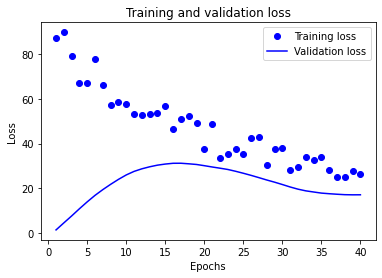

In [ ]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

loss값에 이어 정확도의 변화를 확인해보니 정확도는 에폭이 진행되면서 증가하다가 어느 시점에서 감소하는 것을 볼 수 있다. 모델의 개선이 필요하다고 생각한다.

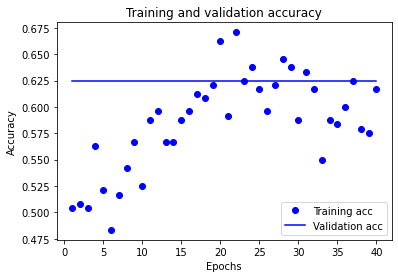

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# 5. 배포

학습시킨 모델에 새로운 데이터를 넣어봤더니 다음과 같이 예측하였다. 이 모델은 다음의 데이터를 입력했을 때 y값을 0으로 예측하였다.

In [ ]:
new_x = [(1, 1), (2, 10), (3, 100), (4, 1000), (5, 10000)]

In [ ]:
model.load_weights('model.hdf5')

y_pred = model.predict(new_x)
print(np.round(y_pred).astype(int))

[[0]
 [0]
 [0]
 [0]
 [0]]


**모델 정확도 향상을 위한 노력**

우리가 모델을 만드는 과정에서는 모델의 성능을 알 수 없다. 모델을 모두 만들고 확인해보니 생각보다 정확도가 낮게 나오는 경우도 더러 있다. 그렇다면 모델의 정확도를 높이기 위해 어떤 방법이 있을지 고민해봐야 한다. 보통 데이터의 전처리가 필요할 때는 모든 데이터의 전처리 과정에서 있지 않은지 확인이 필요하고, 모델을 만들면서 우리가 정하는 여러가지 함수나 수가 있다. 최적화 함수나 에폭수, 배치 사이즈, random_state를 의미한다. 어떤 값이 가장 높은 정확도를 도출시키는지 모르기 때문에 고민이 깊어진다.

그래서 최적의 조합을 찾을 수 있는 그리드 서치 방식이나 랜덤 서치 방식이 제공된다고 한다. 하지만 계산해야 하는 파라미터가 많아지면 그만큼 시간이 길어지는 단점도 있다. 이런 고민을 해결하기 위해 사람 대신 기계가 최적의 파라미터를 조합해 높은 성능을 낼 수 있도록 오토 ML(자동화 기계학습)이 개발되었다고 한다.

* 출처 : https://magazine.hankyung.com/business/article/202101061704b